# Predicting and Exploring Heart Disease through Cholesterol, Blood Pressure, and Age 
#### By Marius Shepherd, Sarenna Ulman, Hayden Hong, Baray Sidhu


# Introduction:

One of the leading causes of death globally is heart disease. While there are many treatments available for different kinds of heart disease, the most important step for a treatment is the initial diagnosis. Hence, it’s paramount that physicians and other health care professionals have access to a program that can predict heart disease using data that is readily available.

We are trying to answer the question:

Is it possible to predict the result of a heart disease diagnosis of a patient based on a patient's cholesterol levels, blood pressure and age through classification?

We will be using the Heart Disease dataset from UCI, linked here:

https://archive.ics.uci.edu/ml/datasets/Heart+Disease Specifically, we used the Cleveland Processed Data, https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
This dataset was taken from the UCI machine learning repository, specifically the Cleveland dataset which takes data of patients from Long Beach and Cleveland Clinic Foundation, taken in 1988.

The dataset contains data regarding heart disease patients and relevant information such as sex, age, cholesterol, max heart rate and more. Other columns include more technical terms, however, many of them will not be used as predictors. More information on our predictors will follow.

Heart disease refers to several types of heart related sicknesses including heart attacks, unstable angina and much more. This data set categorizes the result of the patient's diagnosis to 4 types of categories: typical angina, atypical angina, non-anginal pain, and asymptomatic. We will be generalizing this to presence and absence of heart disease, with asymptomatic being absence and the rest being presence of heart disease.

Our variables of interest:

age: age of the patient recorded \
cholesterol: Serum cholesterol, or total cholesterol recorded in mg/dl in each patient \
rbp: resting blood pressure, blood pressure of patient at rest \
disease: the result of diagnosis for heart disease, we will categorize 0 to be absence and 1-4 to be presence, ignoring the stage and severity of the heart disease. 

# Methods & Results:

We will be using age, resting blood pressure and cholesterol levels as predictors for our data analysis. We can visualize the results of using a classification model by getting the accuracy using collect_metrics and the confusion matrix to asses our model, or plotting our predictors with each other to see a correlation. This can be plotted to further visualize our accuracy results. We will use knn classification to predict whether or not new patients will develop heart disease based on their age, blood pressure, and cholesterol levels.

Predictors:

Age:
	According to the National Institute on Aging, individuals that are older have a higher likelihood of having heart disease. This is the case as there is an “increased stiffness of large arteries” that contributes to the “buildup of fatty deposits in the walls of arteries.”

https://www.nia.nih.gov/health/heart-health-and-aging

Cholesterol: 
	According to cleveland clinic, cholesterol “leads to a buildup of plaque inside your blood vessels”. This buildup of plaque then “limits how much blood can flow,” thus, causing heart disease as well as other medical conditions. Our visualizations also support this.
	
https://my.clevelandclinic.org/health/articles/11918-cholesterol-high-cholesterol-diseases

Resting Blood Pressure:
	According to the Centers for Disease Control and Prevention, having a higher resting blood pressure can “damage arteries by making them less elastic.” This leads to being less blood flow to the heart.

https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina.


In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("cowplot")
library(cowplot)
install.packages("kknn")
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.1.3”
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ pars

## Loading the Data

We will first load and clean the data. We must name the columns to useful names, and select the predictors we will be using. We will also ensure no unknown values are included, which were only denoted by a ? mark. We will also factor the catergorical data and rename the category of heart disease for simplifying the training process.

In [2]:
# reading the data, it does not have column names
heart_disease <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"),
                         col_names = FALSE)

# labelling columns, which are absent in the original dataset
colnames(heart_disease) <- c("age", "sex", "chest_pain_type", "rbp", "cholesterol", 
                      "fbs", "rer",
                      "max_heart_rate","eia", "STdep",
                      "slope","ca", "thal", "disease")

# choosing only relevant predictors
heart_disease <- heart_disease |> select(age, rbp, cholesterol, disease)

# filter when data is unknown (the website tells us there are some unknown values, and they are labelled with "?")
heart_disease <- heart_disease |> filter(age != "?")
heart_disease <- heart_disease |> filter(rbp != "?")
heart_disease <- heart_disease |> filter(age != "?")
heart_disease <- heart_disease |> filter(cholesterol != "?")
heart_disease <- heart_disease |> filter(disease != "?")


# renaming heart disease categories to absence or presence. This simplifies the training process.
heart_disease <- heart_disease |>
             mutate(disease = case_when(disease == 0 ~ "absence", 
                                    disease == 1 ~ "presence",
                                    disease == 2 ~ "presence",
                                    disease == 3 ~ "presence",
                                    disease == 4 ~ "presence"))

# changing categorical data to factors, in which the presence or absence of disease is
heart_disease <- heart_disease |> 
        mutate(disease = as_factor(disease))

heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,rbp,cholesterol,disease
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,absence
67,160,286,presence
67,120,229,presence
⋮,⋮,⋮,⋮
57,130,131,presence
57,130,236,presence
38,138,175,absence


## Splitting and Table of Predictors

We will now split the data to a training and testing set. This is for the purpose differeitiating what data to create the trained model and use the testing dataset for assesing the performance of our predictive model. We will split to 75% and 25%, which is a good balance between testing accuracy and model accuracy. 


In [3]:
# Splitting the data, we will be splitting to 75% and 25%, with strata = num to keep the distribution consistent
set.seed(1)
# we set seed to keep this consistent when others run it
heart_split <- initial_split(heart_disease, prop = 0.75, strata = disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Now, we will create a table to summarize each of our predictors to understand the characteristics of each predictor. We will find the number of observations to understand how large our training data is, which may help us in the furture how we may increase accuracy by increasing this number. We will also take our average age of the patients to understand what age group this model may be relavant to. Furthermore, we take the average of serum cholestroel and blood pressure to observe how patients of this dataset compares with an average person. 

In [4]:
## Table of data analysis

# Getting the mean of the age 
average_age <- heart_train |> summarise(mean(age))

# Number of observations of patients (number of patients/data) in the training set
num_obs <- tibble(nrow(heart_train))

# average of serum cholesterol, which is total cholesterol in body, used as a predictor
avg_chol <- heart_train |> summarise(mean(cholesterol))

# average of resting blood pressure 
avg_rbp <- heart_train |> summarise(mean(rbp))

# number of people with heart disease (any type) 
num_presence <- heart_train |> filter(disease == "presence")
num_hd <- tibble(nrow(num_presence))

In [5]:
# putting together to one table
data_analysis <- bind_cols(num_obs, average_age, avg_chol, avg_rbp, num_hd)

colnames(data_analysis)  <- c("Number of Observations (Patients)", "Average Age", "Average Serum Cholesterol in mg/dl", "Average Resting Blood Pressure (mmHg), High", "Number of Patients with Diagnosed Heart Disease")

data_analysis

Number of Observations (Patients),Average Age,Average Serum Cholesterol in mg/dl,"Average Resting Blood Pressure (mmHg), High",Number of Patients with Diagnosed Heart Disease
<int>,<dbl>,<dbl>,<dbl>,<int>
227,54.9207,246.9604,132.7709,104


*Table 1, summary of dataset and our predictors*

### Analysis via Summarizing
The table summarizes the average of age, which can tell us that the age distribution is reasonably around 54. This helps us know that the dataset is a good representation of heart disease patients in terms of age. 

We have also averaged the predictors such as average cholesterol, average resting blood pressure, and counted the number of patients with heart disease. This gives us insight in how it compares with actual averages in real life. For example, average serum cholesterol is around 200 to 240 mg/dl (milligrams per deciliter), which show that this dataset and higher than average serum cholesterol in their blood. With regards to resting blood pressure, which the dataset refer to the upper number, is 131 mm Hg (millimeters mercury). This is slightly higher than the safe level, almost to hypertension level (dangerous). This provides good insight on what kind of patients are in the dataset and understand the characteristics of our model.

## Plotting Predictors

Now we may plot our predictors to further visualize our training set and its characteristics. We will use a scatterplot and a box plot to do so. This will help us later understand reasons for accuracies/inaccuracies of our model.

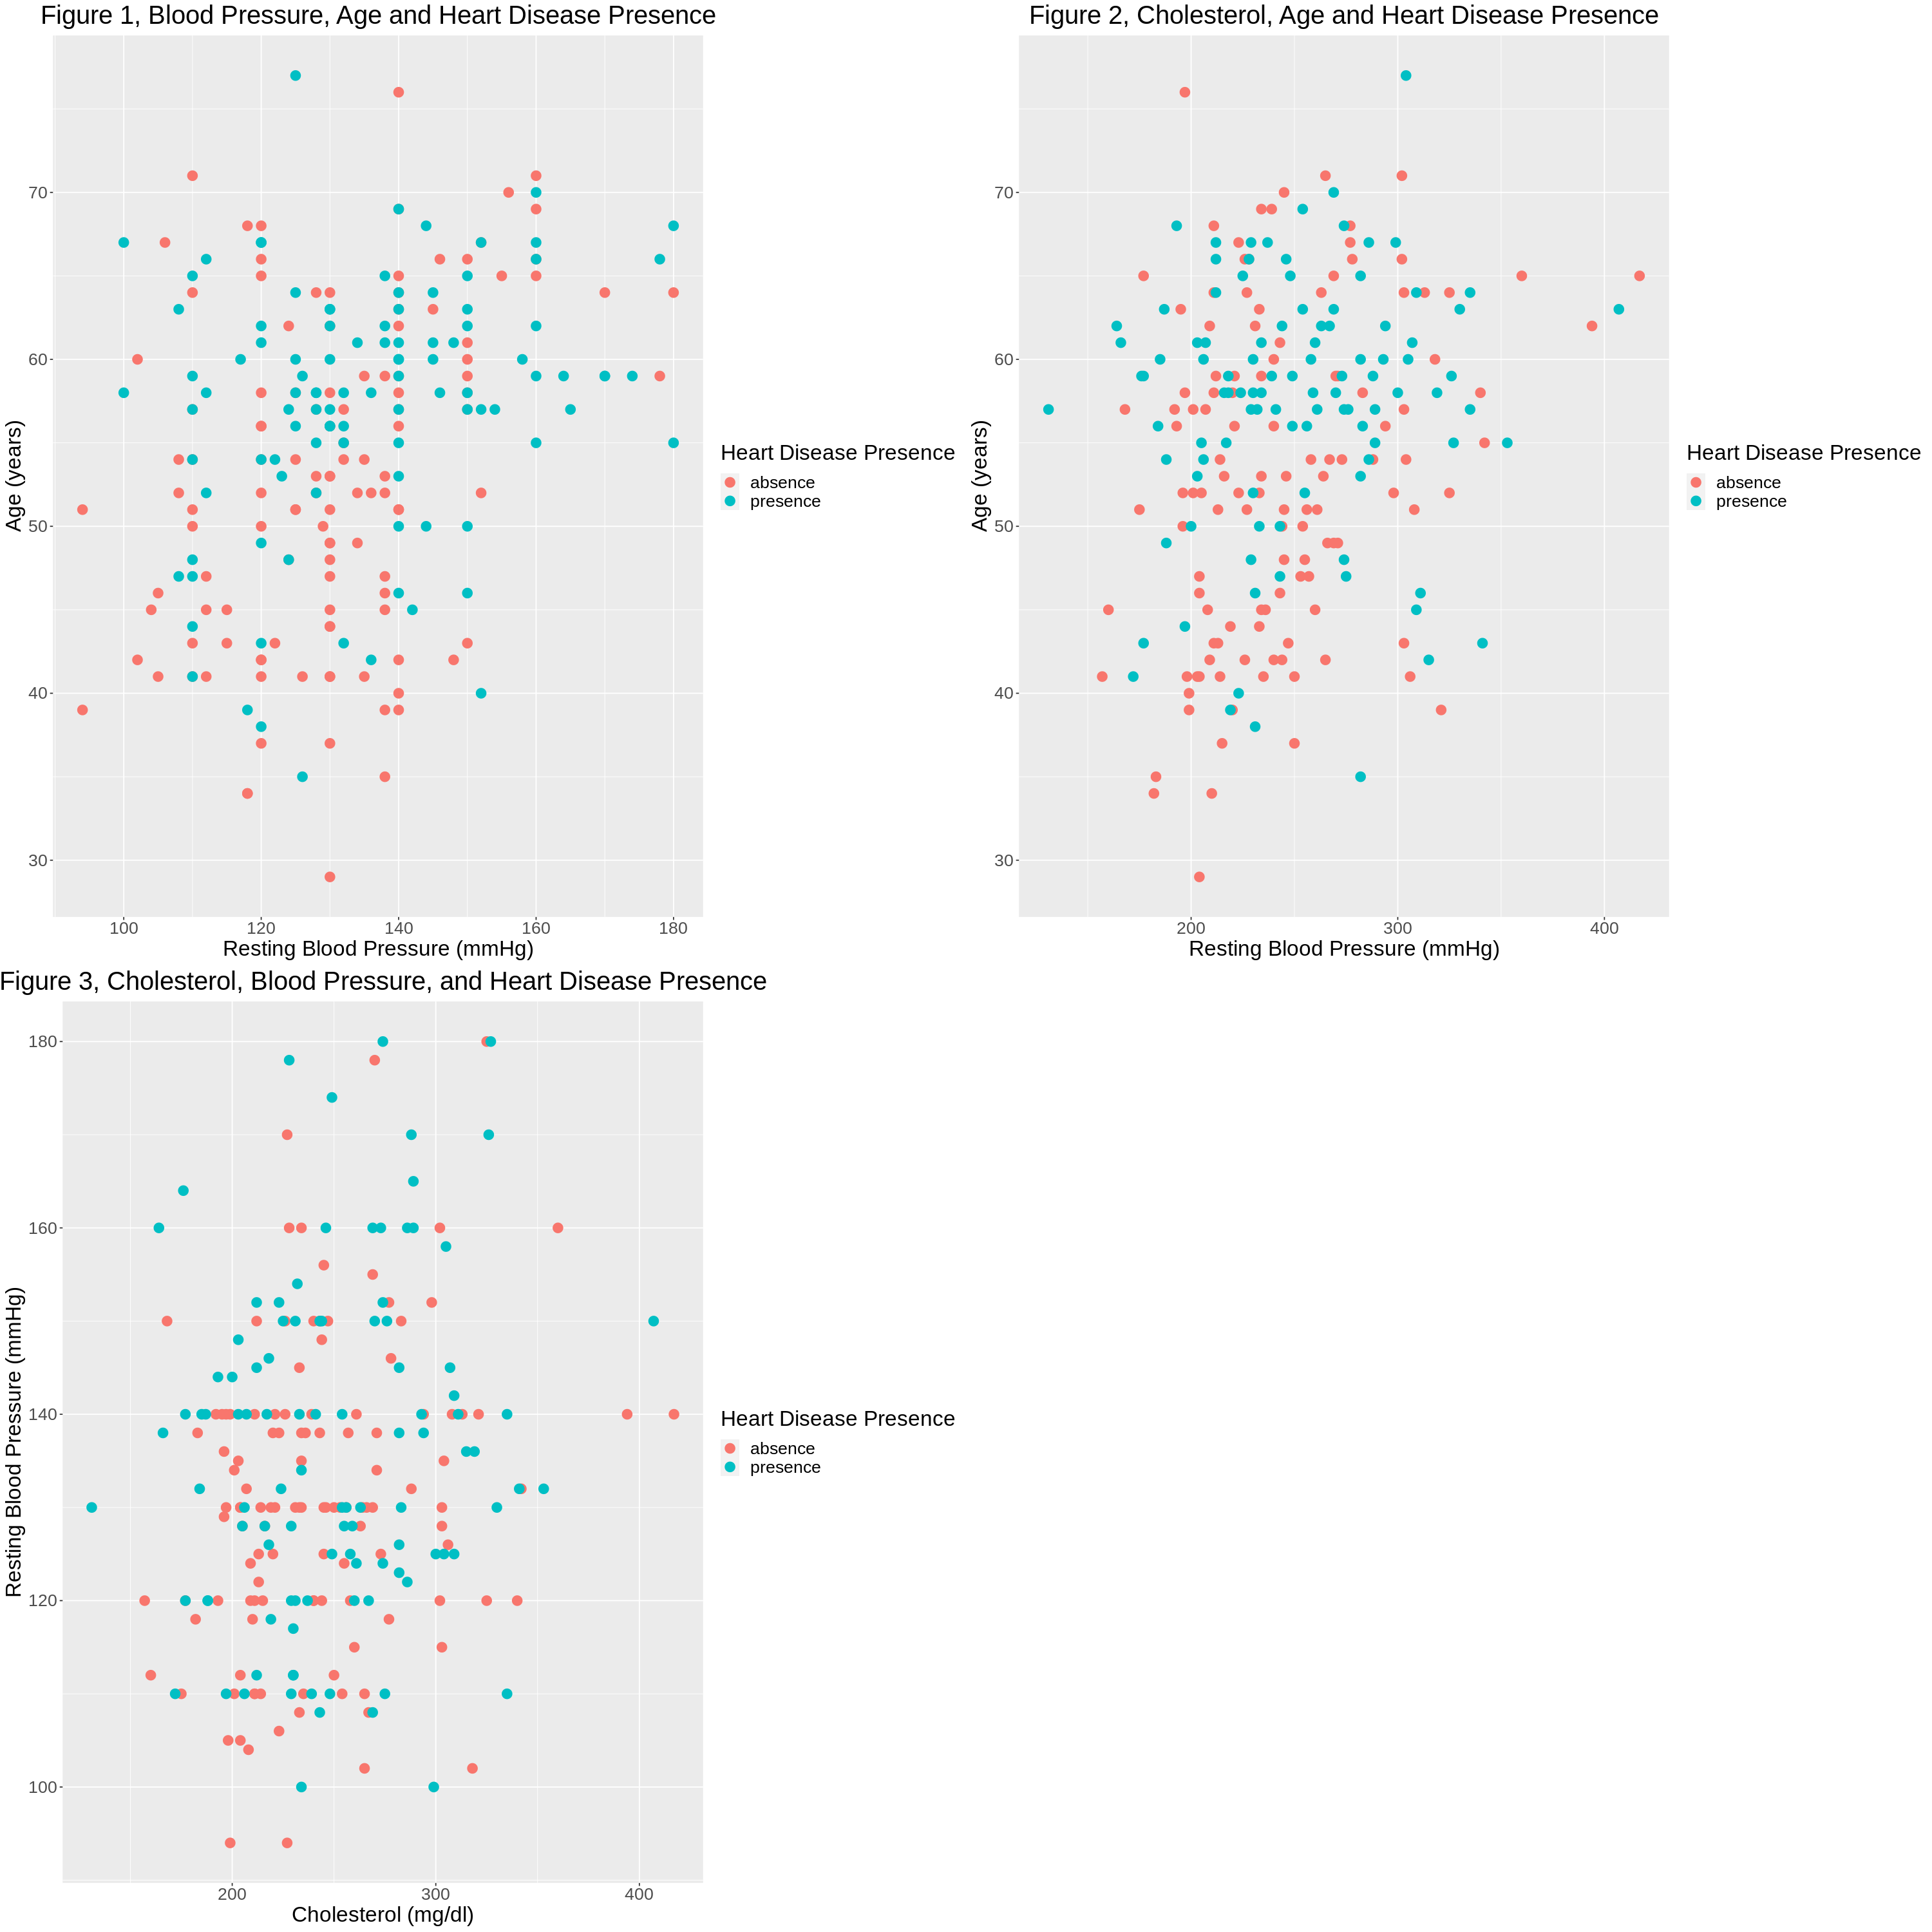

In [6]:
# plotting for data analysis
options(repr.plot.width = 25, repr.plot.height = 25) 

# plotting each predictor against each other and grouping by color
scatter_plot1 <- heart_train |> ggplot(aes(x= rbp, y= age, color = disease)) + geom_point(size = 4) + 
            labs(x= "Resting Blood Pressure (mmHg)", y="Age (years)", color = "Heart Disease Presence") +
            ggtitle("Figure 1, Blood Pressure, Age and Heart Disease Presence") +
            theme(text=element_text(size=20)) +
            theme(plot.title = element_text(hjust = 0.5))
scatter_plot2 <- heart_train |> ggplot(aes(x= cholesterol, y= age, color = disease)) + geom_point(size = 4) + 
            labs(x= "Resting Blood Pressure (mmHg)", y="Age (years)", color = "Heart Disease Presence") +
            ggtitle("Figure 2, Cholesterol, Age and Heart Disease Presence") +
            theme(text=element_text(size=20)) +
            theme(plot.title = element_text(hjust = 0.5))
scatter_plot3 <- heart_train |> ggplot(aes(x= cholesterol, y= rbp, color = disease)) + geom_point(size = 4) + 
            labs(x= "Cholesterol (mg/dl)", y="Resting Blood Pressure (mmHg)", color = "Heart Disease Presence") +
            ggtitle("Figure 3, Cholesterol, Blood Pressure, and Heart Disease Presence") +
            theme(text=element_text(size=20)) +
            theme(plot.title = element_text(hjust = 0.5))

# plot all together using cowplot
plot_grid(scatter_plot1, scatter_plot2, scatter_plot3)


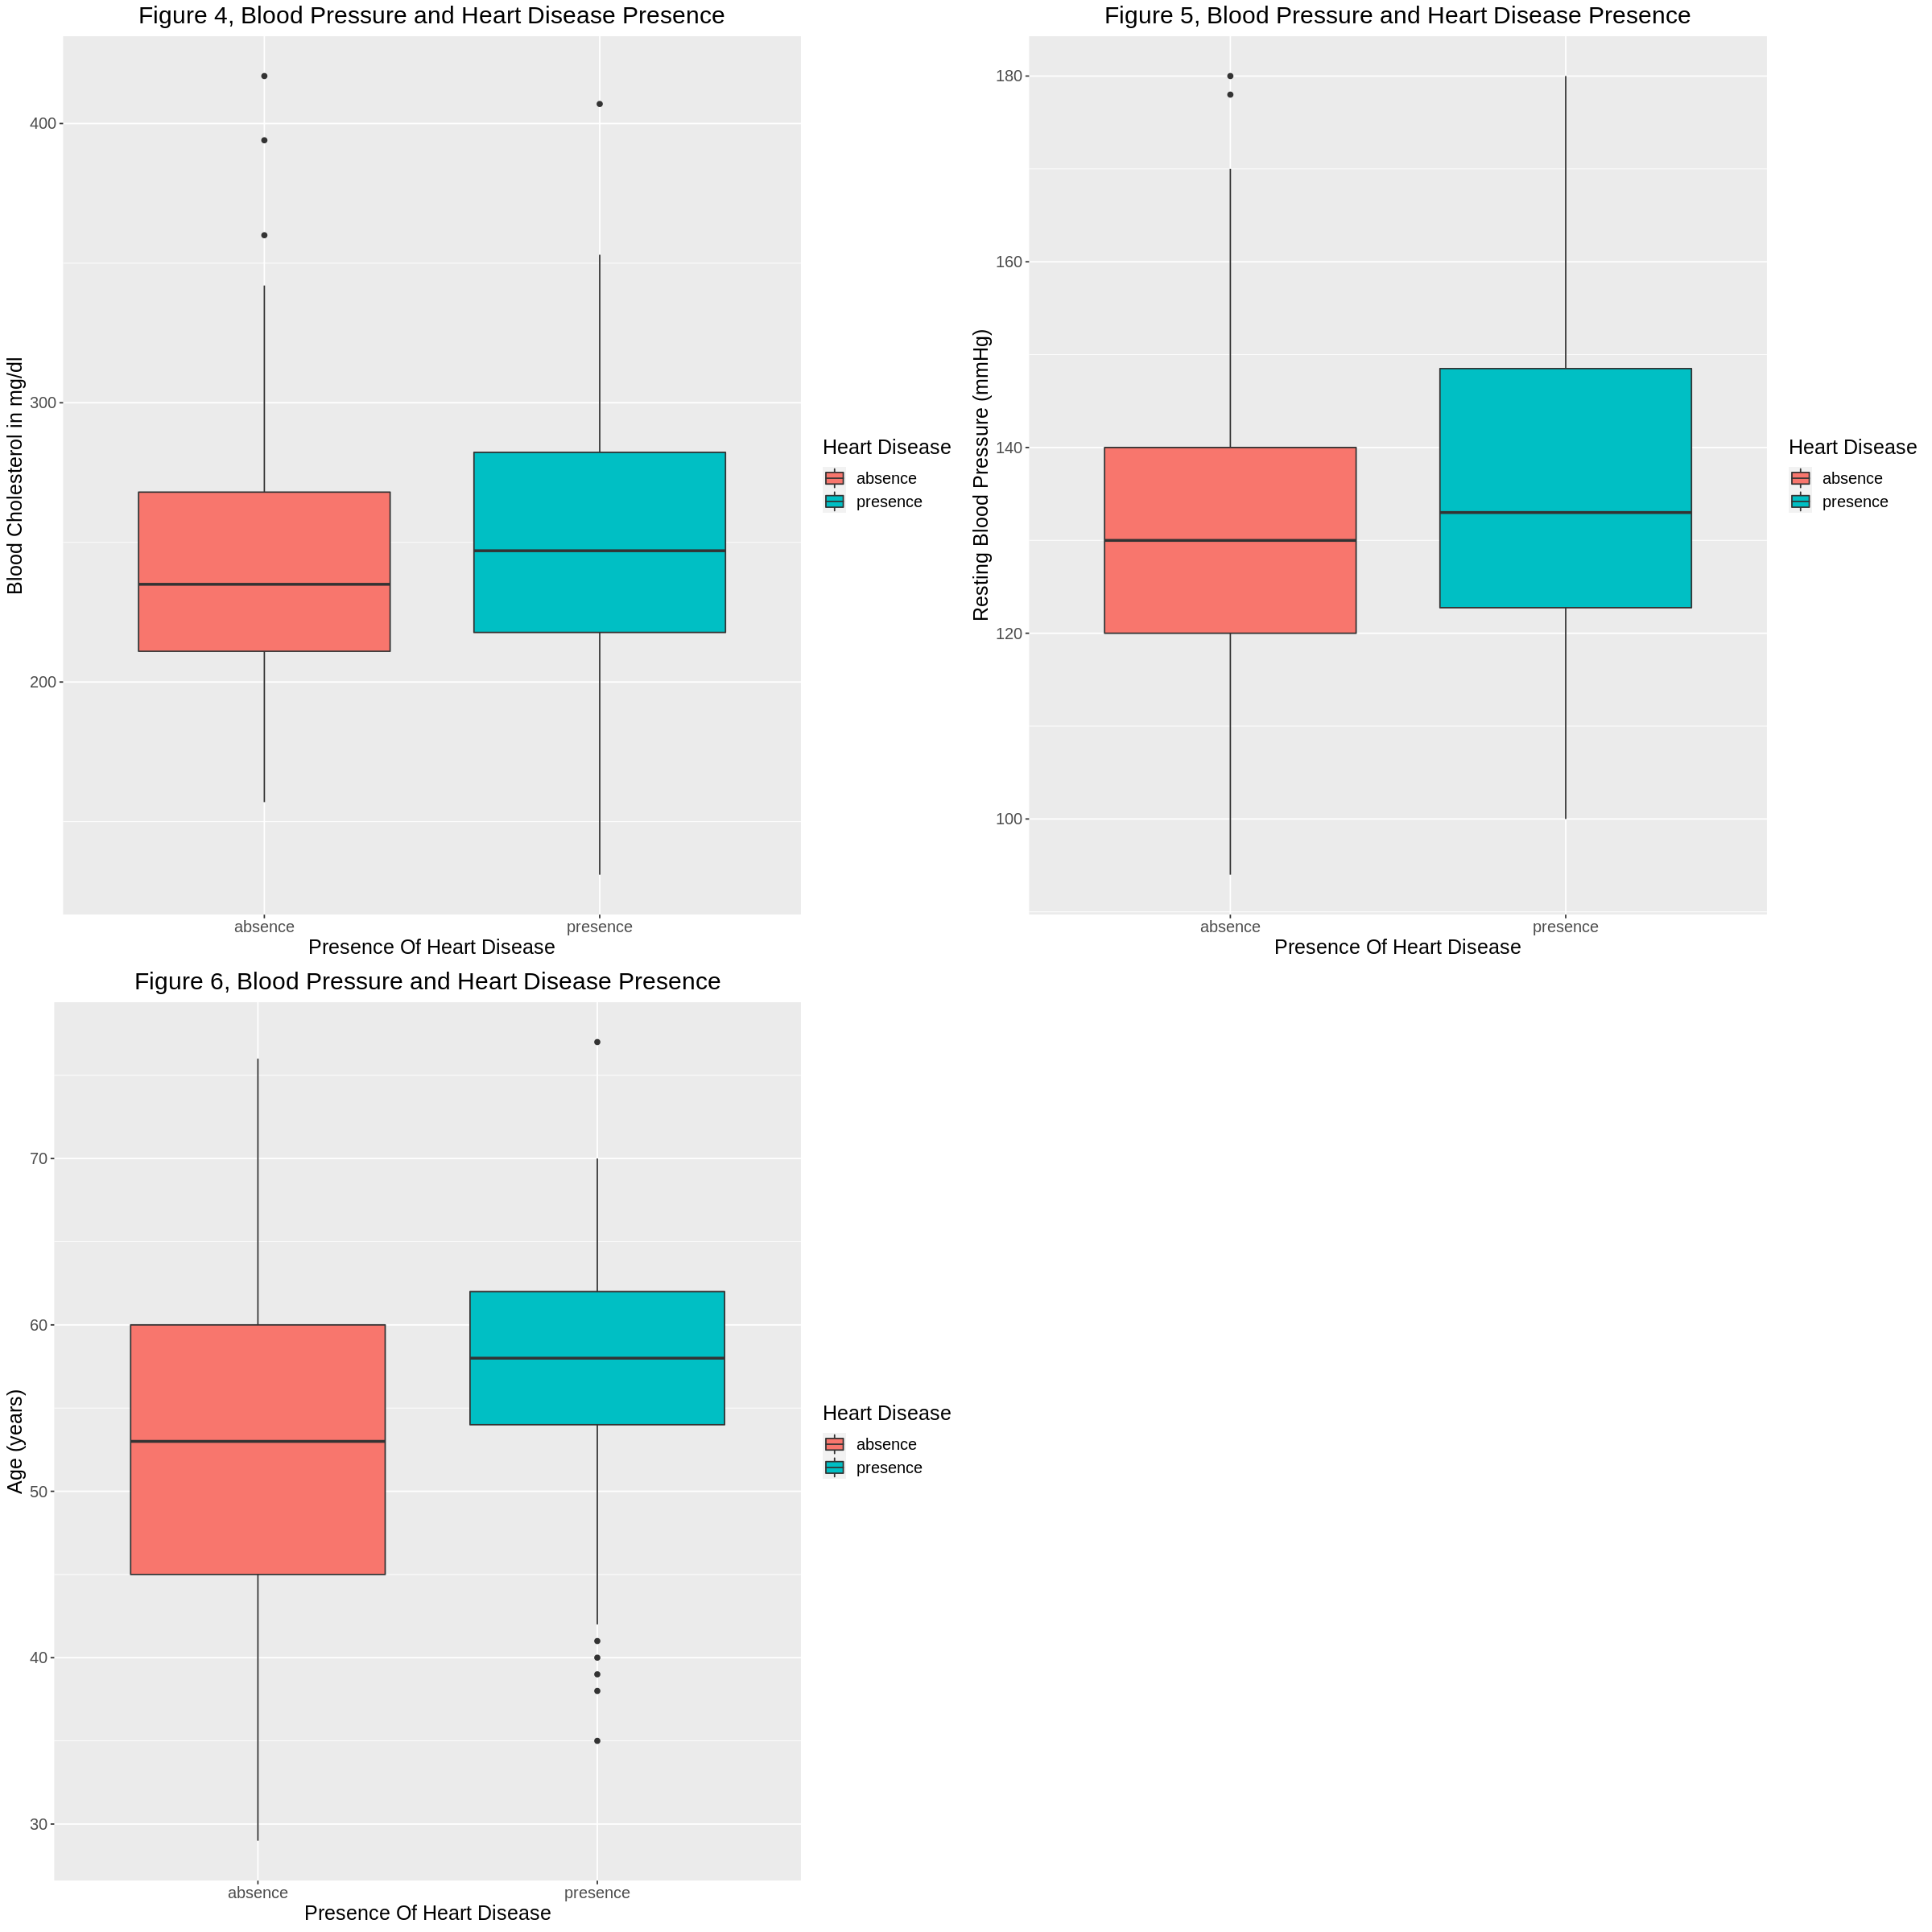

In [7]:
options(repr.plot.width = 20, repr.plot.height = 20) 

cholesterol_boxplot <- heart_train |> ggplot(aes(x= disease, y = cholesterol, fill = disease)) + geom_boxplot() + 
            labs(x= "Presence Of Heart Disease", y="Blood Cholesterol in mg/dl", fill ="Heart Disease") +
            ggtitle("Figure 4, Blood Pressure and Heart Disease Presence") +
            theme(text=element_text(size=15)) +
            theme(plot.title = element_text(hjust = 0.5))
rbp_boxplot <- heart_train |> ggplot(aes(x= disease, y = rbp, fill = disease)) + geom_boxplot() + 
            labs(x= "Presence Of Heart Disease", y="Resting Blood Pressure (mmHg)", fill ="Heart Disease") +
            ggtitle("Figure 5, Blood Pressure and Heart Disease Presence") +
            theme(text=element_text(size=15)) +
            theme(plot.title = element_text(hjust = 0.5))
age_boxplot <- heart_train |> ggplot(aes(x= disease, y = age, fill = disease)) + geom_boxplot() + 
            labs(x= "Presence Of Heart Disease", y="Age (years)", fill ="Heart Disease") +
            ggtitle("Figure 6, Blood Pressure and Heart Disease Presence") +
            theme(text=element_text(size=15)) +
            theme(plot.title = element_text(hjust = 0.5))

# plot all together using cowplot
plot_grid(cholesterol_boxplot, rbp_boxplot, age_boxplot)

### Visualization

The first set of plots are sactter plots of each of our predictors against each other, grouped by the presence of heart disease. We see across all the scatter plots, there is no clear grouping of data points with their presence or absence of heart disease. This may indicate that the predictors are not good in making predictions. 

The second set of plots are box plots of each predictor, grouped by the presence of absence of heart disease. We see that for blood cholesterol and resting blood pressure, there is no significant difference in the distribution of the rpedictor among patients with heart disease or wwithout it.This means the amount of cholesterol/high blood pressure may not be able to predict the presence of heart disease. However, we see that in the third boxplot, there is a noticable difference in the age group of people with the presence of heart disease. However, because there is still significant overlap in the age groups where heart disease was presence vs absent, we cannot say age itself is a good predictor.

# Performing the Data Analysis

We will now perfrom the data analysis to answer our question. We will use KNN classification to create a classifier to predict patients heart disease diagnosis. First, we will figure the best k value, or the number of neighbors the k nearest classification algorithm uses to have maximum accuracy using the vfold function. We first scale and set up the recipe for the classifier, using our predictors. We will set neighbors as tune() as we will perform cross validation and see acuracies across many k values to determine the k value that results in the highest accuracy.

In [8]:
heart_recipe <- recipe(disease ~ age + rbp + cholesterol, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

We will now conduct cross validation with 5 folds and do so for k values 1 to 50. Cross validation ensures that the accuracy of the model accuracy is valid by using different sets of training/validation sets. We would asses the accuracy of each k value cross validation by the collect metrics function. Because of the size of our dataset shown table 1, (227) we may reasonably expect the k value to be low, or to be in this range (1-50).

In [9]:
# performing 5 cross validation
heart_vfold <- vfold_cv(heart_train, v = 5, strata = disease)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))
# apply different k values, performing cross validation for each k value
knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()

Now, we may represent in a table our results, showing the neighbors and their corresponding accuracy, represented as the mean.

In [10]:
accuracies <- knn_results |>
    filter(.metric == "accuracy") |> select(neighbors, mean)

accuracies

neighbors,mean
<dbl>,<dbl>
1,0.5509267
2,0.5509267
3,0.5292885
⋮,⋮
48,0.5693983
49,0.5648529
50,0.5648529


*Table 2, result of cross validation and tuning*

Visualizing our results, we may see the k value that induces the greatest accuracy, and also find manually using the arrange function.

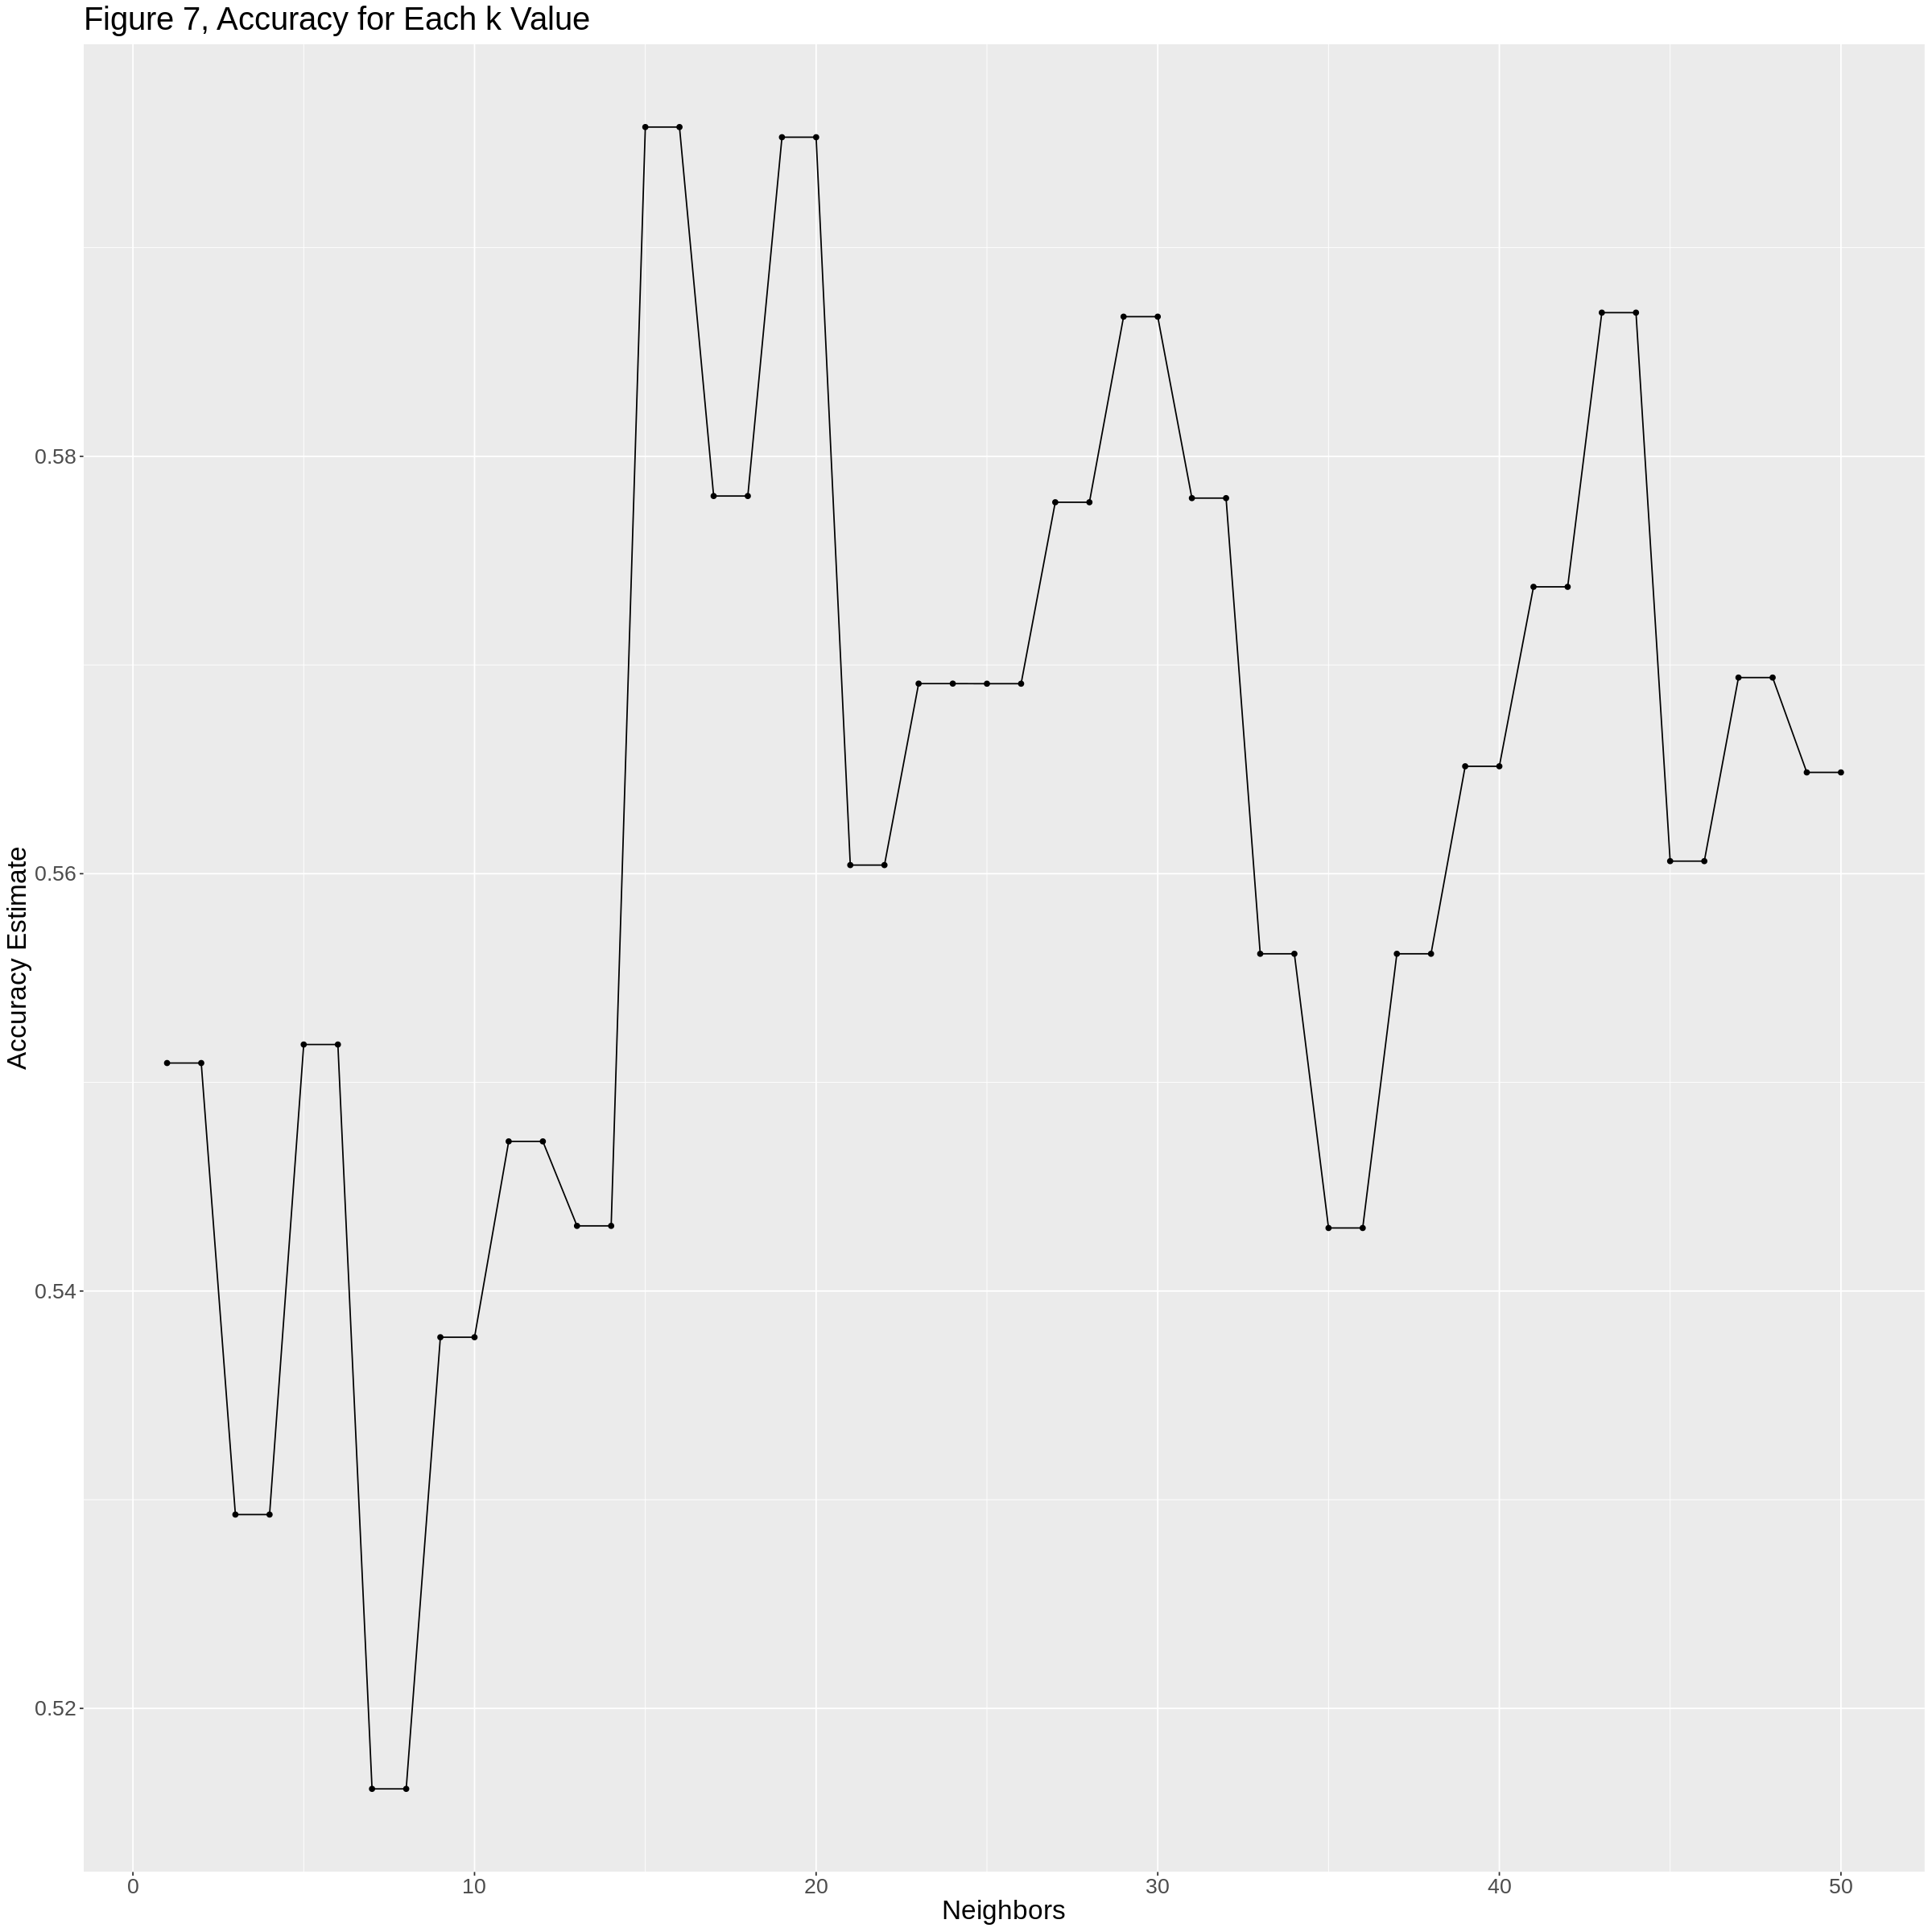

In [11]:
accuracy_vs_k <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 7, Accuracy for Each k Value")
accuracy_vs_k

In [12]:
max_accuracy_k <- accuracies |> arrange(desc(mean)) |> select (neighbors)|> head(1) |> pull()
max_accuracy_k

[1] 15

This concludes that we should use a k value of 15 to use in our KNN classification. Using our test data, we may assess the RMSPE of our classification model, which will show us our results of our predictor. We will create a workflow and fit our KNN classification model to our training set, and assess the accuracy by making predictions using the test data. We will create a table with the predicted value and the true value in the test dataset.

In [13]:
knn_spec_15 <- nearest_neighbor(weight_func = "rectangular", neighbors = max_accuracy_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_15 <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec_15) |>
    fit(data = heart_train)

heart_test_prediction <- predict(knn_fit_15, heart_test) |>
    bind_cols(heart_test)

heart_test_prediction 

.pred_class,age,rbp,cholesterol,disease
<fct>,<dbl>,<dbl>,<dbl>,<fct>
presence,56,120,236,absence
presence,62,140,268,presence
absence,57,120,354,absence
⋮,⋮,⋮,⋮,⋮
absence,45,110,264,presence
presence,57,130,236,presence
absence,38,138,175,absence


*Table 4, Predictors, predicted class by model and the true result*

Now, using this table we will assess the accuracy of our model by using the metrics function, comparing the true value and predicted value.

In [14]:
heart_test_prediction |> 
            metrics(truth = disease, estimate = .pred_class) |> 
            filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6447368


*Table 5, Accuracy of model*

We see that our accuracy is approximately 65%. We will further investigate this value.

Now, we will also see the confusion matrix of our model that was tested using the testing set. We will be able to see how may incorrect predictions we had and correct predictions we had. We will visualizse this as a bar graph.

In [15]:
confusion <- heart_test_prediction |> 
            conf_mat(truth = disease, estimate = .pred_class)
confusion

          Truth
Prediction absence presence
  absence       30       16
  presence      11       19

*Table 6, Confusion Matrix, showing accurate and inaccurate predictions* 

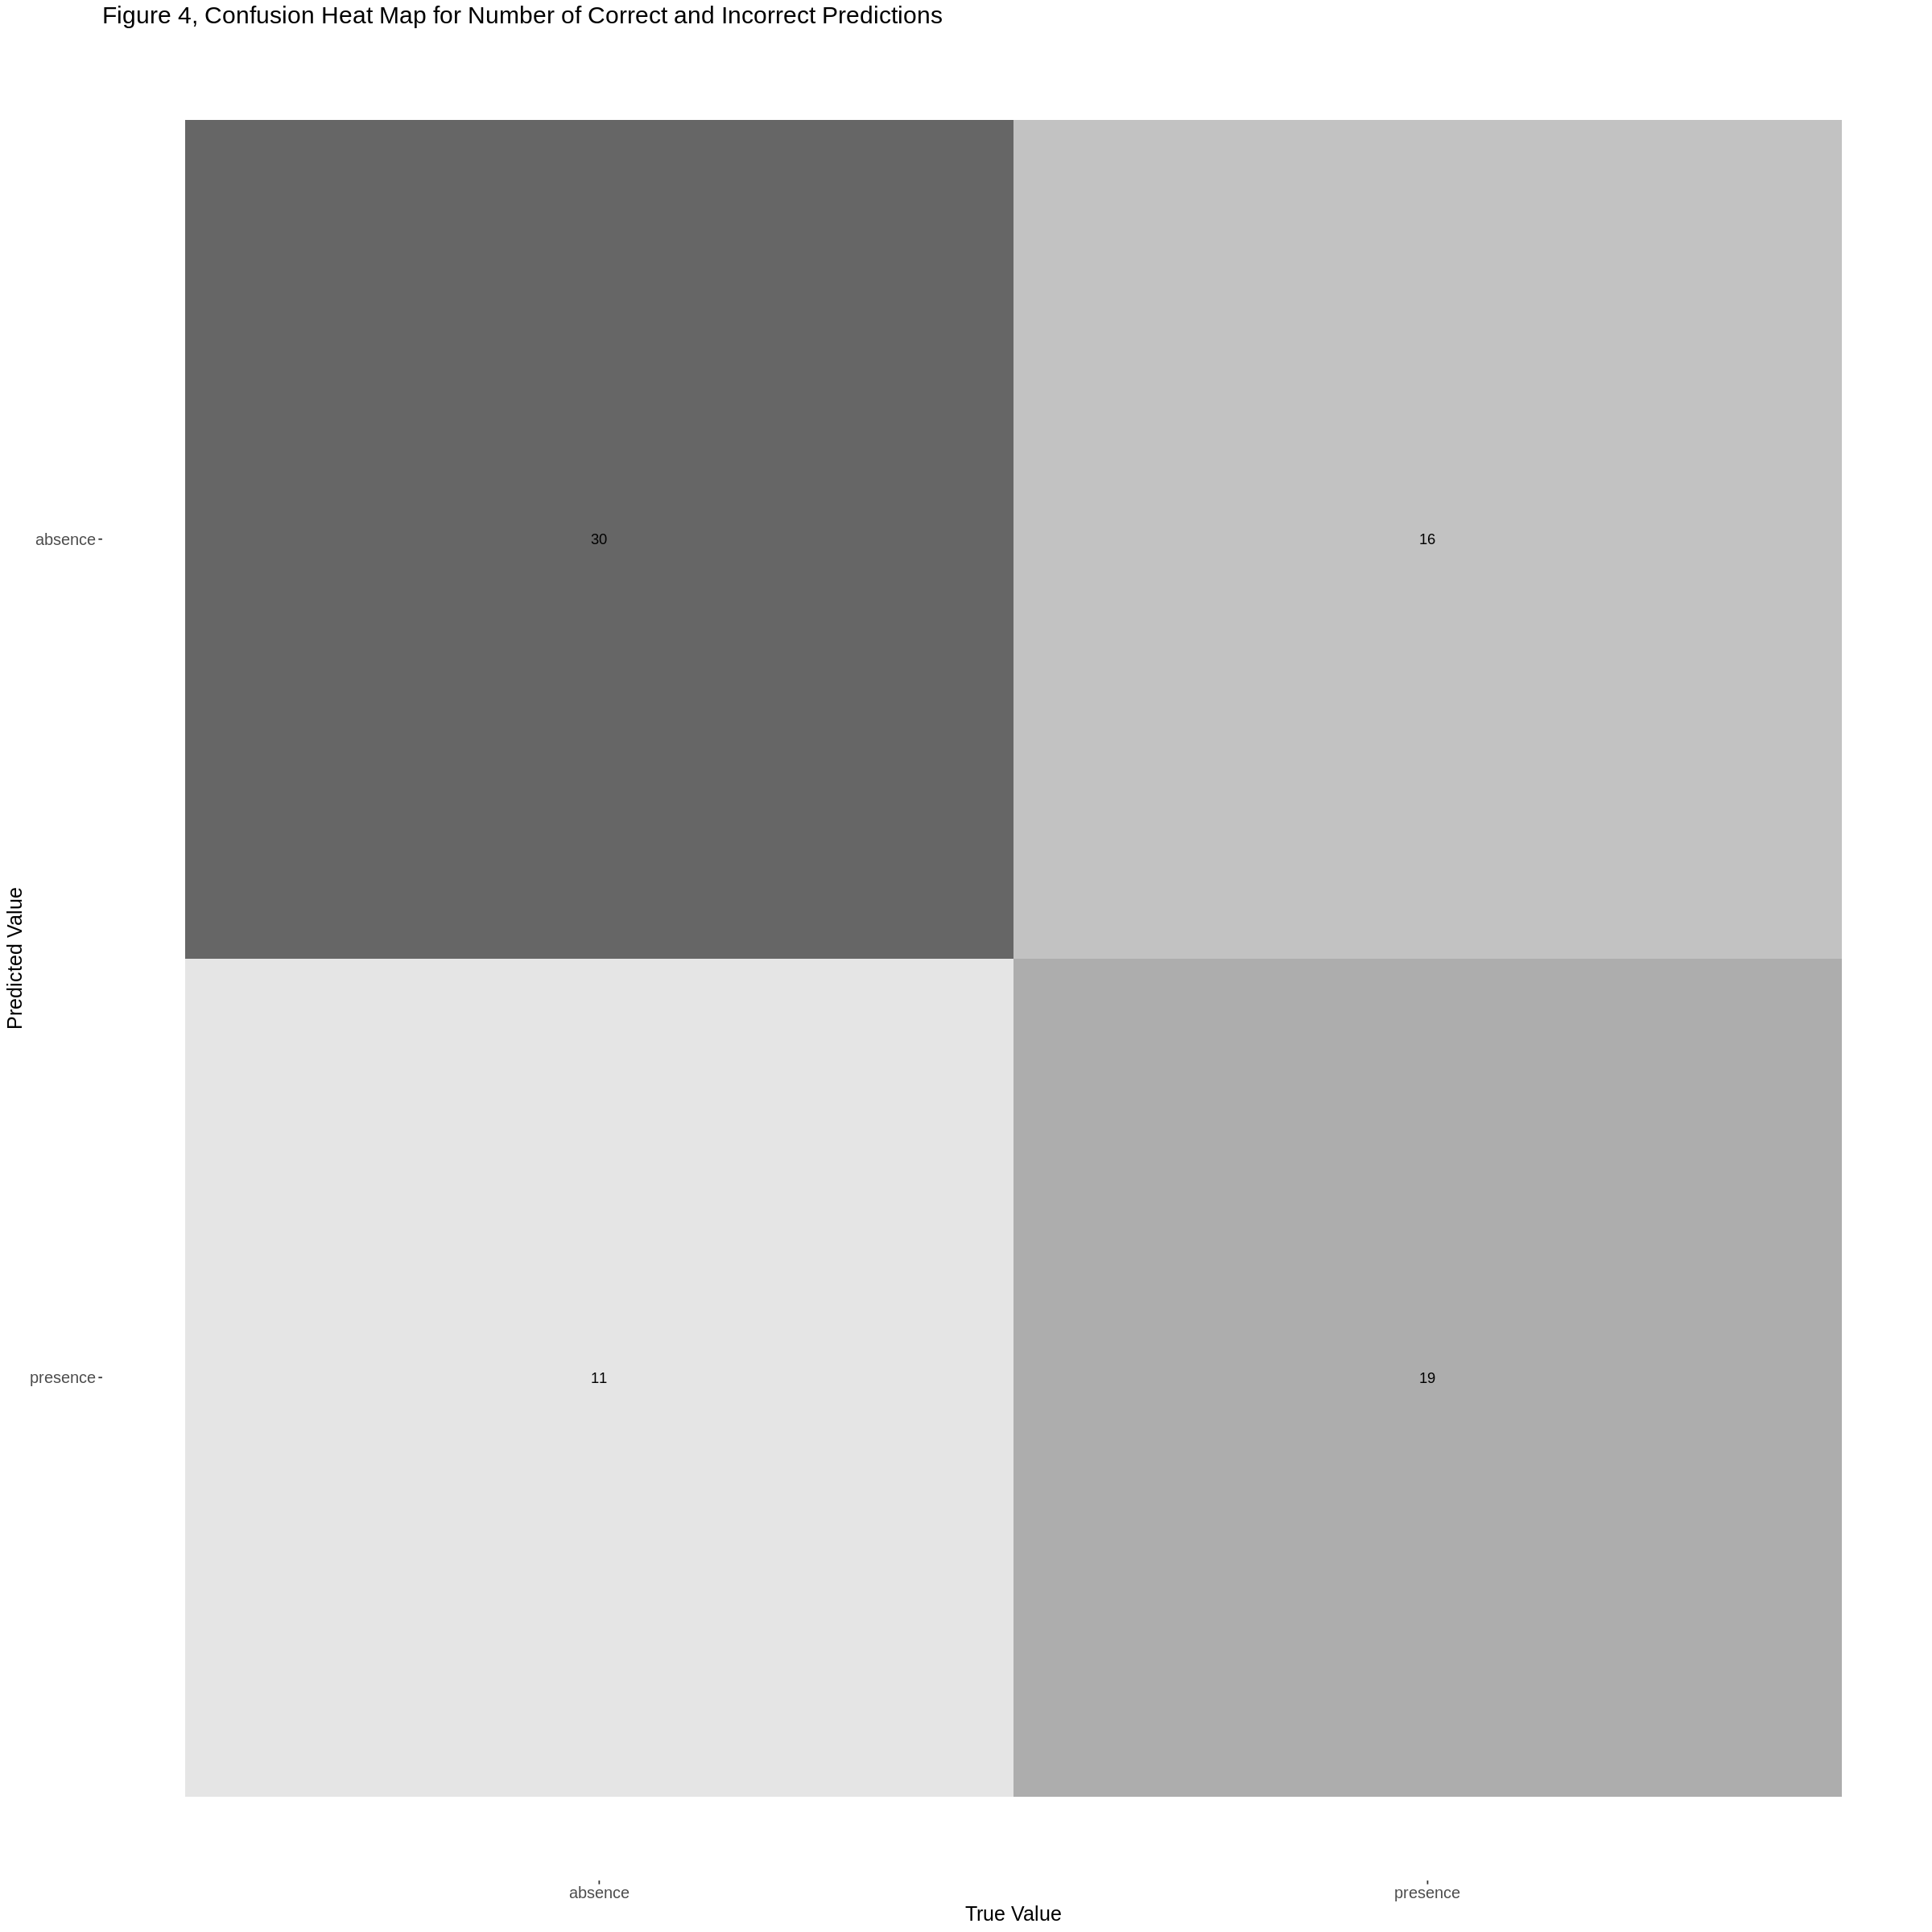

In [16]:
autoplot(confusion, type = "heatmap") + labs(x= "True Value", y= "Predicted Value") +
theme(text = element_text(size = 15)) + 
ggtitle("Figure 4, Confusion Heat Map for Number of Correct and Incorrect Predictions")

We will first map the correctness of the values for age and cholesterol. We may create a new column that determines
if the predicted value was correct or not, and see if we can identify a cause for the incorrect predictions.

In [17]:
# creating a new column to represent the correctness of the prediction
correctness_assess <- heart_test_prediction |> mutate(Correctness=case_when(.pred_class == "presence" & disease == "absence" ~ "incorrect",
                                                      .pred_class == "absence" & disease == "presence" ~ "incorrect",
                                                     .pred_class == "presence" & disease == "presence" ~ "correct",
                                                     .pred_class == "absence" & disease == "absence" ~ "correct"))
# change this new column to a factor, as it is catergorical
correctness_assess <- mutate(correctness_assess, Correctness = as_factor(Correctness))
# label incorrect values as incorrect in prediction class,leave everything else as is
correctness_assess <- correctness_assess |> mutate(.pred_class=case_when(Correctness == "incorrect" ~ "incorrect",
                                                                         Correctness == "correct" & .pred_class == "presence" ~ "presence",
                                                                         Correctness == "correct" & .pred_class == "absence" ~ "absence"))
correctness_assess


.pred_class,age,rbp,cholesterol,disease,Correctness
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
incorrect,56,120,236,absence,incorrect
presence,62,140,268,presence,correct
absence,57,120,354,absence,correct
⋮,⋮,⋮,⋮,⋮,⋮
incorrect,45,110,264,presence,incorrect
presence,57,130,236,presence,correct
absence,38,138,175,absence,correct


*Table 6, corectness of model and incorrectness of predicted class*

In [18]:
# first plot against age and cholesterol, with the correctness of the prediction
correctness_plot1 <- ggplot() + 
                    geom_point(data = correctness_assess, mapping = aes(x = age, 
                           y = cholesterol, 
                           color = .pred_class, shape = .pred_class), 
                             alpha = 10, size = 5) + 
                    ggtitle("Figure 5, Correctness of Prediction against Cholesterol and Age") + 
                    labs(x="Age (years)", y= "Cholesterol in mg/dl") +
                    theme(text = element_text(size = 15)) 

In [19]:
# second plot against age and blood pressure, with the correctness of the prediction
correctness_plot2 <- ggplot() + 
            geom_point(data = correctness_assess, mapping = aes(x = age, 
                           y = rbp, 
                           color = .pred_class, shape = .pred_class), 
             alpha = 10, size = 5) + 
            labs(x="Age (years)", y= "Resting Blood Pressure (mmHg)") +
            ggtitle("Figure 6, Correctness of Prediction against Blood Pressure and Age") + 
            theme(text = element_text(size = 15)) 

In [20]:
# third plot against cholesterol and blood pressure, with the correctness of the prediction
correctness_plot3 <- ggplot() + 
                    geom_point(data = correctness_assess, mapping = aes(x = rbp, 
                           y = cholesterol, 
                           color = .pred_class, shape = .pred_class, group = .pred_class), 
                             alpha = 10, size = 5) + 
                     labs(x="Resting Blood Pressure (mmHg)", y= "Cholesterol in mg/dl") +
                    ggtitle("Figure 7, Correctness of Prediction against Cholesterol and Age") + 
                    theme(text = element_text(size = 15)) 

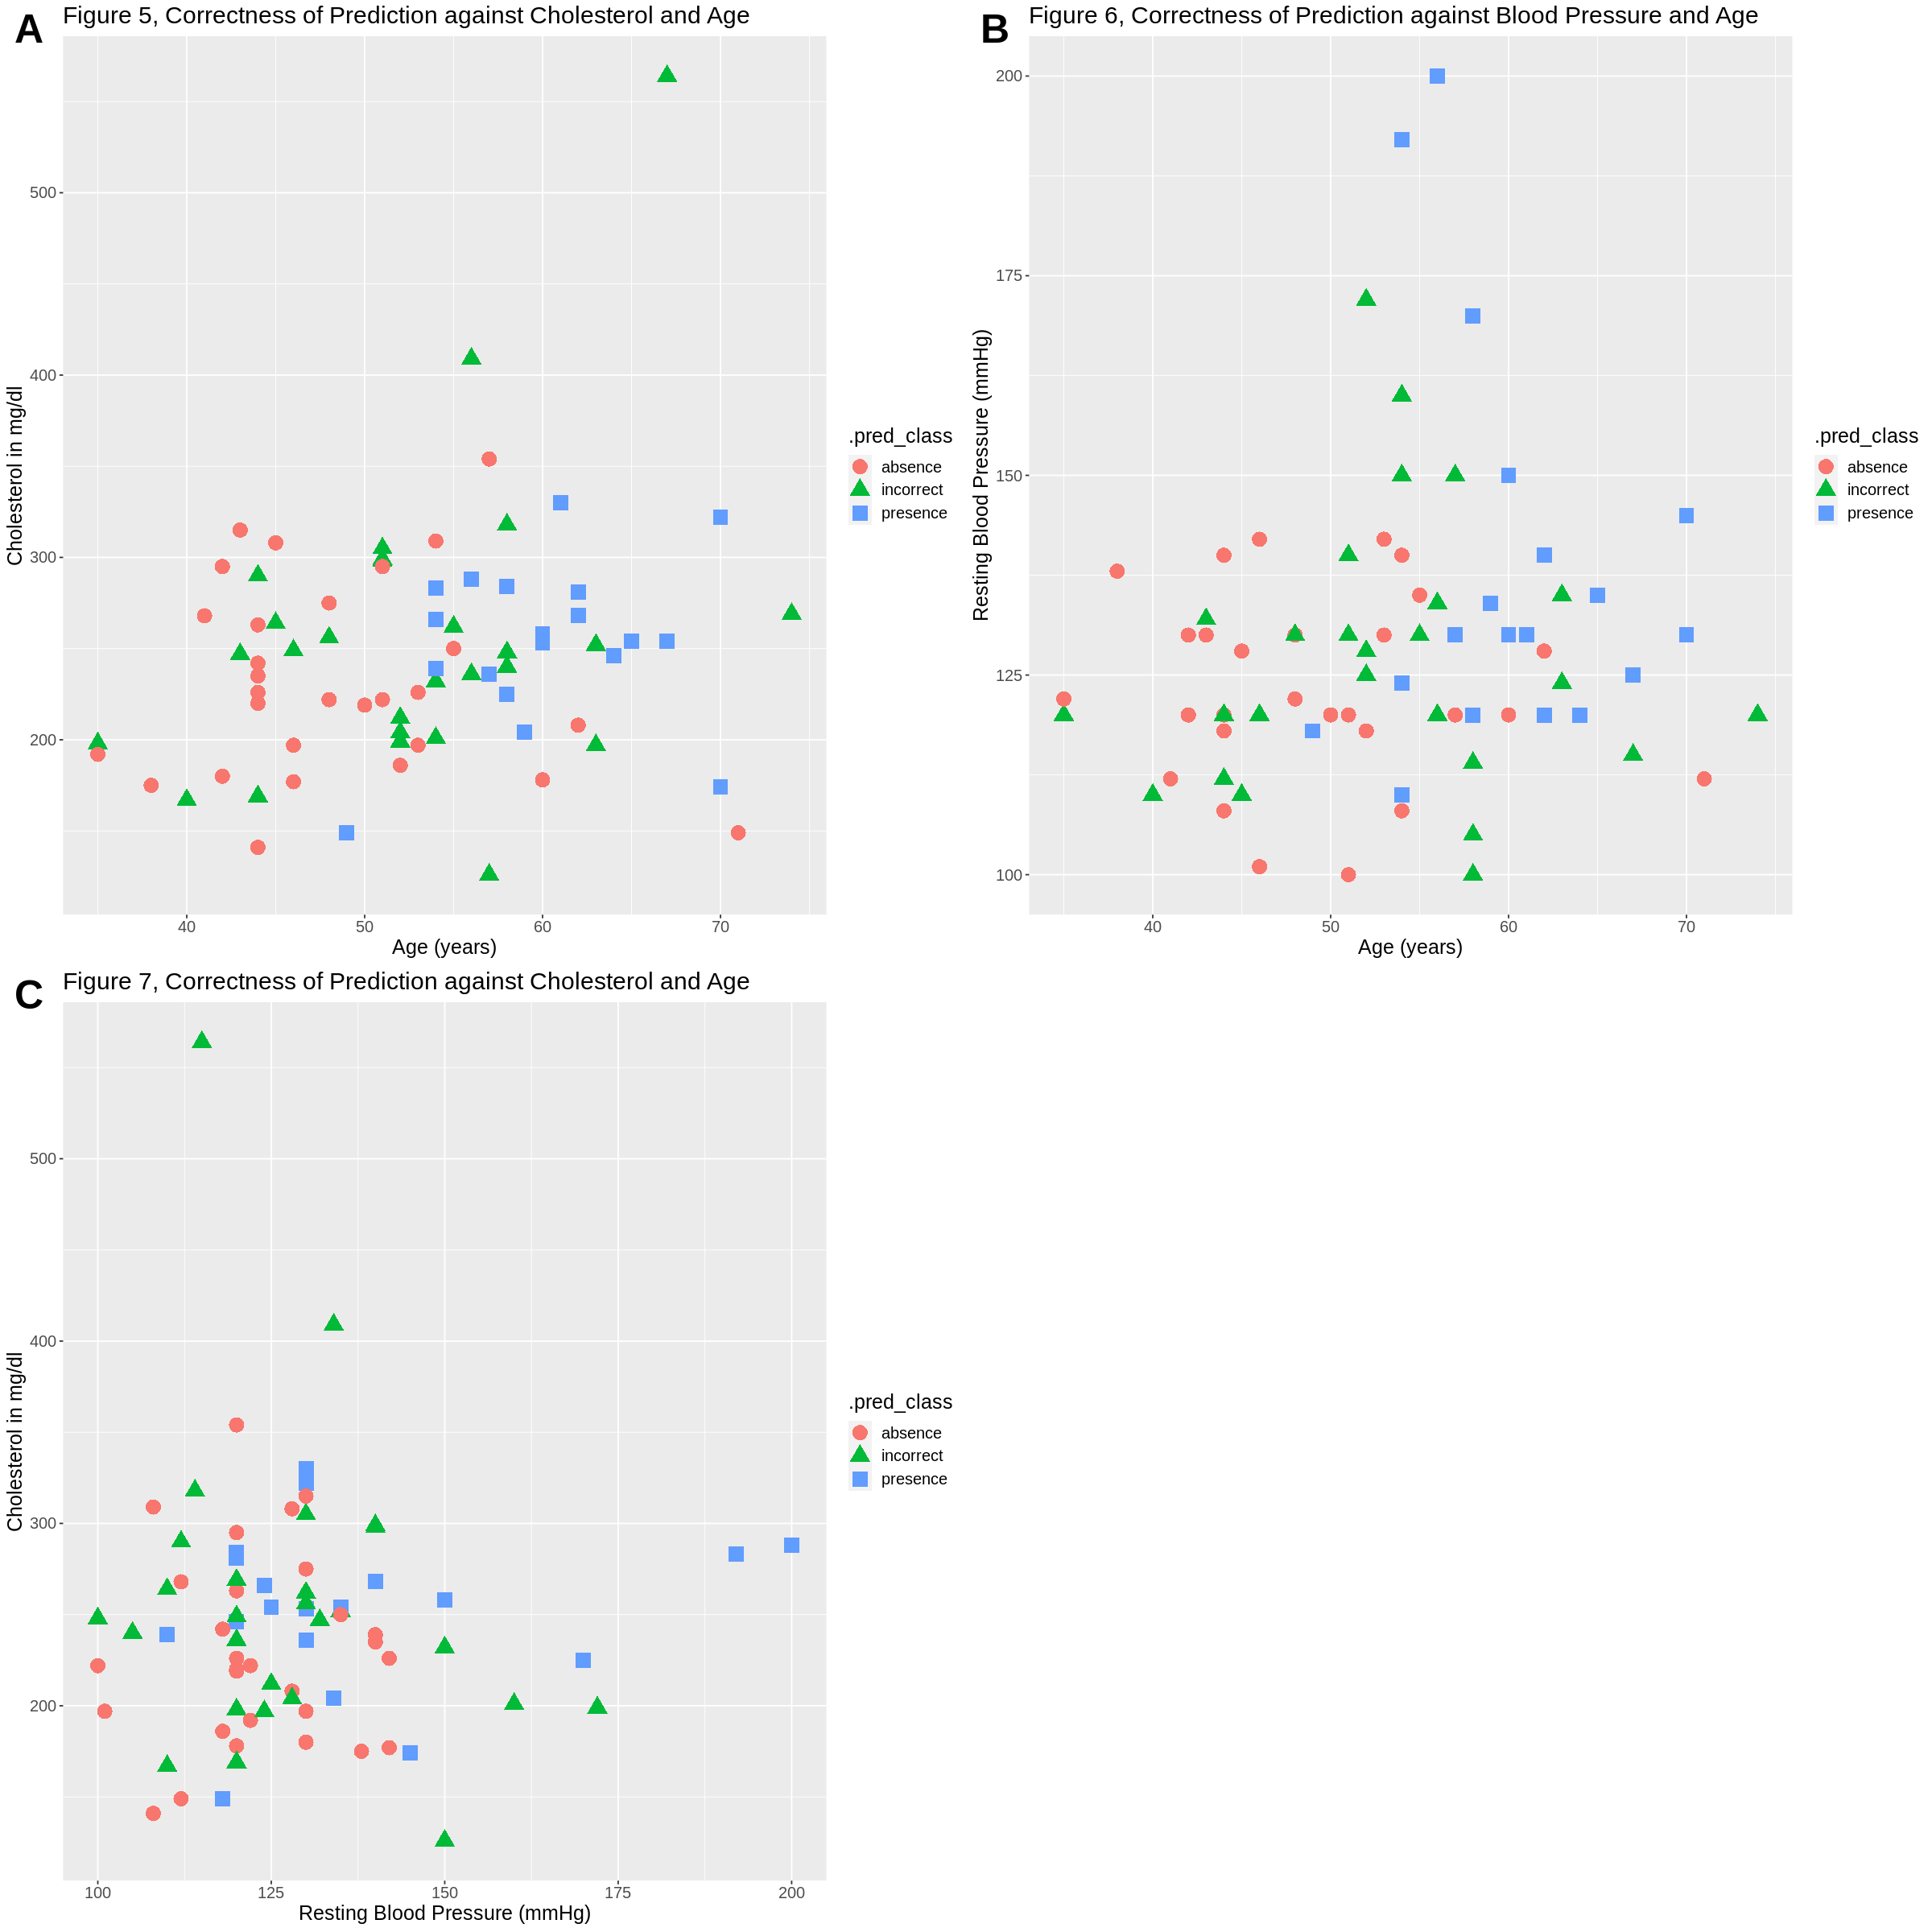

In [21]:
# usage of plot_grid from the cowplot library, to have graphs side by side
options(repr.plot.width = 20, repr.plot.height = 20) 
plot_grid(correctness_plot1, correctness_plot2, correctness_plot3, labels = "AUTO", label_size = 30)


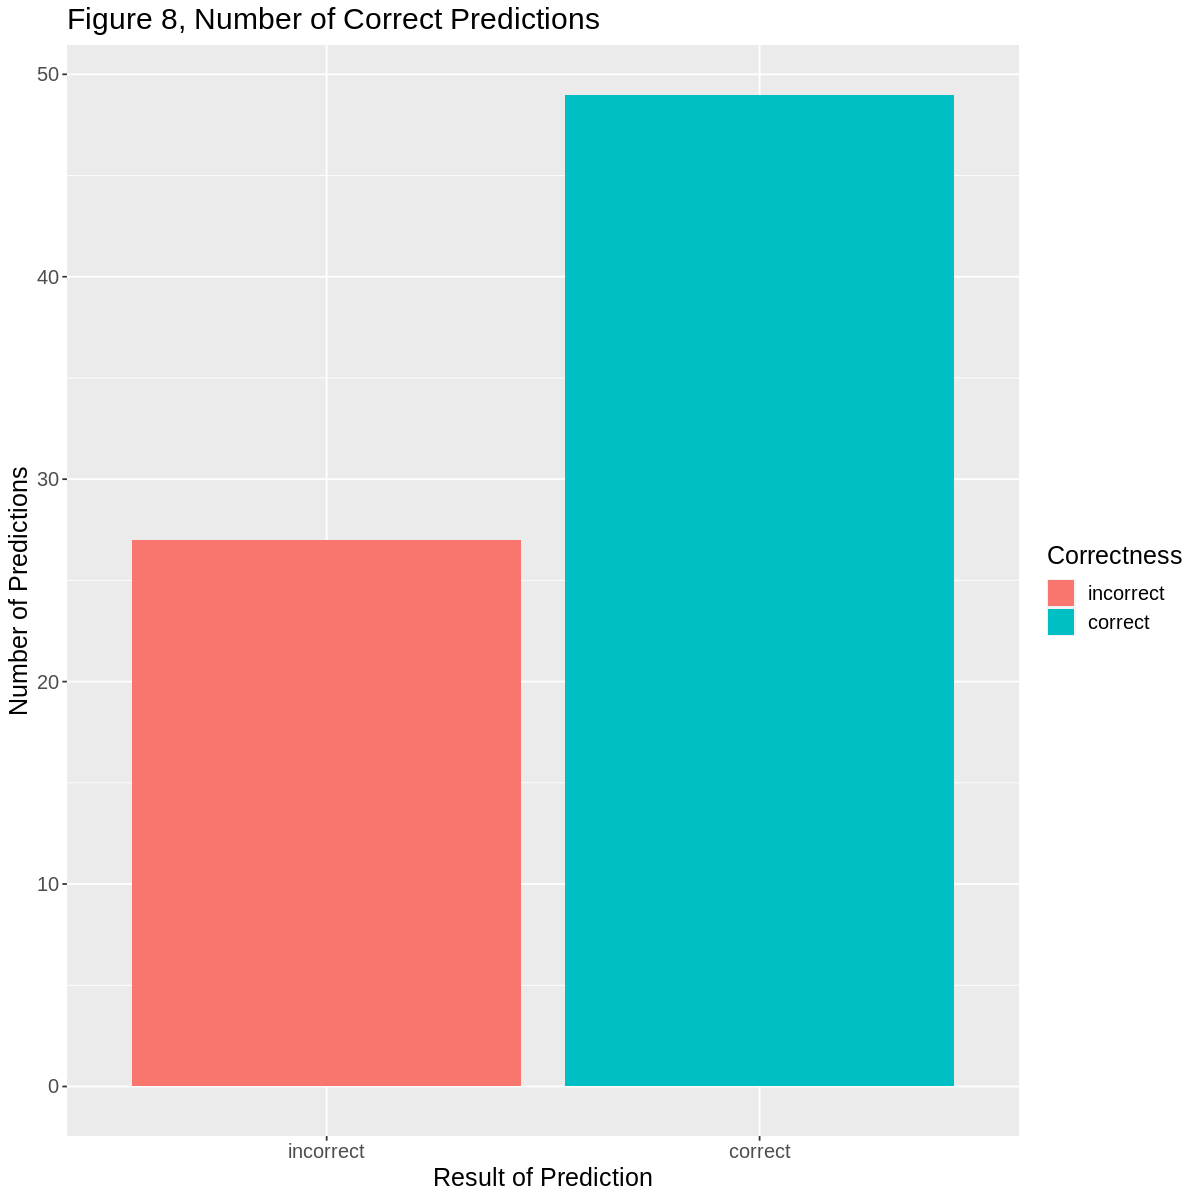

In [22]:
# bar graph to represent correct number of predictions and incorrect predictions
options(repr.plot.width = 10, repr.plot.height = 10) 

correctness_barplot <- correctness_assess |> ggplot(aes(x = Correctness, fill = Correctness)) + 
geom_bar(position = "dodge") + labs(y = "Number of Predictions", x = "Result of Prediction") + 
ggtitle("Figure 8, Number of Correct Predictions") + theme(text = element_text(size = 15))

correctness_barplot

In figures 5 6 and 7, we see the incorrect predictions made plotted with the predictors. We see that none of the predictors have any consistent grouping with the incorrect predicitons. This means we cannot tell which predictor is not good

We see that there were 30 correct predictions of the absence of heart disease, and 11 incorrect predictions. There were 19 correct predictions of presence and 16 predictions of absence. Nearly half of our predictions are incorrect which is not good in the context of heart disease. We may further investigate by comparing with the majority classifer. It may turn out that our dataset naturally had more of heart disease presence than absence.

The cause of this low is likely due to our predictors not being clearly grouped well: we see that when we have plotted in our data anlaysis that all predictors did not have clear groups to differientiate when heart disease is present or absent. Despite the promising analysis for age in Figure 3, we see that the age predictor did not result in a high accuracy, seen in figures Figure 5 and 6. We may observe the majority classifier and compare the accuracy of our model to truly put in context our results.

In [23]:
heart_train_proportions <- heart_train |>
                      group_by(disease) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_train))

heart_train_proportions

disease,n,percent
<fct>,<int>,<dbl>
absence,123,54.18502
presence,104,45.81498


*Table 8, Percentage of absence/presence of heart disease in training set*

We see that a majority classifier will have 54% accuracy in predicting absence of heart disease. Hence, we can say that our model does at least have an higher percentage than this at 64%, but far from good, in the context of heart disease. We do not want a patient with heart disease to be diagnosed without heart disease, as this puts patients at great risk. We may also compare the majority classfifier with the whole dataset and confirm that we have successfully split the data with representation. We will further discuss the results of our accuracy compared with the majority classifier, the plots given above to hypothesize why our model has its inaccuracies in the discussion section.

In [24]:
heart_proportions <- heart_disease |>
                      group_by(disease) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_disease))

heart_proportions

disease,n,percent
<fct>,<int>,<dbl>
absence,164,54.12541
presence,139,45.87459


*Table 9, Percentage of absence/presence of heart disease in full dataset*

We see that the training set has successfully repreented the whole dataset, hence we may trust that the majority classifier is accurate for the training set.

# Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

The data analysis shows that as age and resting blood pressure increase, so does the proportion of heart disease in a population - suggesting there to be a positive relationship. For example, a 50 year old with a resting blood pressure of 110 mmHg is significantly less likely to have heart disease than a 70 year old with 160mmHg resting blood pressure. In addition to this, the amount of blood cholesterol has a positive relationship with developing heart disease: the higher the blood cholesterol, the more likely it is the individual has heart disease. These findings agree with the literature. The heart weakens as a person ages; and a higher resting blood pressure is a measure of how fast the heart is pumping blood through the body, meaning, it’s logical to assume that higher blood pressure could lead to heart disease since the heart is working harder. Higher blood cholesterol being correlated with the presence of heart disease is expected as well, since the heart has to work harder to pump blood through smaller arteries. These findings could help prevent heart disease. While you can't prevent getting older, you can live a healthy lifestyle to keep your resting blood pressure and blood cholesterol levels low. In the future, possible research questions include specific and effective ways to lower resting blood pressure and blood cholesterol, or if certain people are genetically predisposed to higher levels of cholesterol and RBP, and therefore, predisposed to heart disease.

Despite our predictors being strong indicators for heart disease, we have a low accurate prediction rate when testing on the testing data at 65%. A reason that may explain this low prediction rate is [ADD MORE HERE]

Reasoning:
- Your predictive question is good, just remove the part that says "regression". You don't need to specify that you'll use classification in the question, but if you do, please say that it's KNN classification.
- How will you show the KNN function on your final graphs? Unclear as to what you mean.
- Your methods are sparse, and you spend a lot of the word count describing your figures, which is unnecessary. For the final project, make sure that any commentary on the figures is truly commentary and not just description.

General Feedback:
- Your future questions should be about the data or the applications of the model, not the model itself.
- Your visualizations are great!! Unique and very descriptive. I'd like to see at least one general scatterplot in the final project but please keep doing interesting things.
- You don't need to read in dplyr as it's part of tidyverse.
- You spend a lot of time talking about diabetes and the effect of blood sugar on heart disease, but the effect itself seems to be fairly small. This makes your project feel somewhat tangential, as you're discussing diabetes but your model is about heart disease. I would like to see equal attention given to each predictor and more words spent discussing the model itself.

The data analysis shows that as age and resting blood pressure increase, so does the proportion of heart disease in a population.  For example, a 50 year old with a resting blood pressure of 110 mmHg is significantly less likely to have heart disease than a 70 year old with 160mmHg resting blood pressure.  The amount of blood cholesterol is found to impact the likelihood of developing heart disease.  The higher the blood cholesterol, the more likely it is the individual has heart disease.  The results are not surprising.  The heart stops working as well as a person ages; and higher resting blood pressure is a measure of how fast the heart is pumping blood through the body, so it makes sense that higher blood pressure could lead to heart disease since the heart is working harder.  Higher blood cholesterol being correlated with the presence of heart disease is expected as well, since the heart has to work harder to pump blood through smaller arteries.  These findings could help prevent heart disease.  While you can't prevent getting older, you can live a healthy lifestyle to keep your resting blood pressure and blood cholesterol levels low.  In the future, possible research questions include specific and effective ways to lower resting blood pressure and blood cholesterol, or if certain people are genetically predisposed to higher levels of cholesterol and RBP, and therefore, predisposed to heart disease.

# References

Data Set:

University of California Irvine. (n.d.). Heart Disease Data Set. UCI Machine Learning Repository: Heart disease data set. Retrieved April 11, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Literature:

Centers for Disease Control and Prevention. (2021, May 18). High blood pressure symptoms and causes. Centers for Disease Control and Prevention. Retrieved April 6, 2023, from https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina.

Centers for Disease Control and Prevention. (2022, June 20). Diabetes and your heart. Centers for Disease Control and Prevention. Retrieved April 6, 2023, from https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html#:~:text=Over%20time%2C%20high%20blood%20sugar,and%20can%20damage%20artery%20walls.

Cleveland Clinic. (n.d.). High cholesterol: Causes, symptoms and how it affects the body. Cleveland Clinic. Retrieved April 6, 2023, from https://my.clevelandclinic.org/health/articles/11918-cholesterol-high-cholesterol-diseases

U.S. Department of Health and Human Services. (2018, June 1). Heart health and aging. National Institute on Aging. Retrieved April 6, 2023, from https://www.nia.nih.gov/health/heart-health-and-aging